# ADS2 - Assignment 1 - Data Handling and Preparation

In this assignment, you will be analysing the popularity of films and TV shows on the streaming platform, Netflix. Using your knowledge of PySpark DataFrames and Spark SQL, you will produce a number of "downstream" data products to analyse trends in global streaming habits.

Download the dataset from this [Kaggle](https://www.kaggle.com/dhruvildave/netflix-top-10-tv-shows-and-films) page. A copy of the `all_weeks_countries.csv` file is also available on the canvas page for this assignment.

Your task is to load in the data and produce a number of "downstream" data products and plots as described below.

The PySpark installation and setup is provided below for conveinience.

In [ ]:
# Apache Spark uses Java, so first we must install that
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Download and unpack the latest version of Spark (3.2.0 as of writing)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

In [ ]:
# Set up environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [ ]:
# Install findspark, which helps python locate the psyspark module files
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
# Finally, we initialse a "SparkSession", which handles the computations
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# Exercise 1 - Data Preparation (5 Marks)


1.   Load the `all_weeks_countries.csv` into your Colab Notebook as a DataFrame.
2.   Create two separate DataFrames for Films and TV.
3.   For the Films data, drop the column containing the season names.
4.   For the TV data, replace any null values in the season name column with the show name.

In [ ]:
# pyspark.sql.functions countains all the transformations and actions you will
# need
from pyspark.sql import functions as F


In [ ]:
### Load the all_weeks_countries.csv into your Colab Notebook as a DataFrame.

csvfile = '/content/sample_data/all-weeks-countries.csv'

df = (spark
      .read
      .option('header',True)
      .option('inferSchema',True)
      .csv(csvfile)
       )


In [ ]:
### Display the table and its schema

df.show()
df.printSchema()

+------------+------------+----------+--------+-----------+--------------------+--------------------+--------------------------+
|country_name|country_iso2|      week|category|weekly_rank|          show_title|        season_title|cumulative_weeks_in_top_10|
+------------+------------+----------+--------+-----------+--------------------+--------------------+--------------------------+
|   Argentina|          AR|2022-03-06|   Films|          1|      Chernobyl 1986|                null|                         2|
|   Argentina|          AR|2022-03-06|   Films|          2|    The Weekend Away|                null|                         1|
|   Argentina|          AR|2022-03-06|   Films|          3|     Against The Ice|                null|                         1|
|   Argentina|          AR|2022-03-06|   Films|          4|            Restless|                null|                         2|
|   Argentina|          AR|2022-03-06|   Films|          5|Spider-Man: Into ...|                n

In [ ]:
### Seperate the data into two DataFrames for Films and TV
tv_df = df.filter('category == "TV"')
films_df = df.filter('category == "Films"') # separating films and tv 

films_df.show()   
tv_df.show()

+------------+------------+----------+--------+-----------+--------------------+------------+--------------------------+
|country_name|country_iso2|      week|category|weekly_rank|          show_title|season_title|cumulative_weeks_in_top_10|
+------------+------------+----------+--------+-----------+--------------------+------------+--------------------------+
|   Argentina|          AR|2022-03-06|   Films|          1|      Chernobyl 1986|        null|                         2|
|   Argentina|          AR|2022-03-06|   Films|          2|    The Weekend Away|        null|                         1|
|   Argentina|          AR|2022-03-06|   Films|          3|     Against The Ice|        null|                         1|
|   Argentina|          AR|2022-03-06|   Films|          4|            Restless|        null|                         2|
|   Argentina|          AR|2022-03-06|   Films|          5|Spider-Man: Into ...|        null|                         1|
|   Argentina|          AR|2022-

In [ ]:
### Drop the 'season_title' column from the Films DataFrame, display the table


films_df = films_df.drop('season_title') # drop chosen column
films_df.show()

+------------+------------+----------+--------+-----------+--------------------+--------------------------+
|country_name|country_iso2|      week|category|weekly_rank|          show_title|cumulative_weeks_in_top_10|
+------------+------------+----------+--------+-----------+--------------------+--------------------------+
|   Argentina|          AR|2022-03-06|   Films|          1|      Chernobyl 1986|                         2|
|   Argentina|          AR|2022-03-06|   Films|          2|    The Weekend Away|                         1|
|   Argentina|          AR|2022-03-06|   Films|          3|     Against The Ice|                         1|
|   Argentina|          AR|2022-03-06|   Films|          4|            Restless|                         2|
|   Argentina|          AR|2022-03-06|   Films|          5|Spider-Man: Into ...|                         1|
|   Argentina|          AR|2022-03-06|   Films|          6|       Lost Paradise|                         2|
|   Argentina|          AR|2

In [ ]:
### Replace any null values in 'season_title' in the TV DataFrame with the
### corresponding 'show_title', display the table
from pyspark.sql.functions import coalesce
from pyspark.sql.functions import isnan, when, count, col

tv_df = tv_df.withColumn('season_title', coalesce('season_title', 'show_title')) # coalesce to replace the null values with the value from show_title


tv_df.filter(col("season_title").isNull()).count() #check if it worked



0

# Exercise 2 - Most popular seasons by country (15 Marks)

1.   For each country in the data, find the highest rank each season of TV reached, and the number of weeks it spent in the top 10.
2.   Produce a DataFrame that contains the season of TV which spent the most time in each country's top 10.
3.   Produce a pie chart which shows how many countries the most popular seasons of TV occurred in. 


In [ ]:
### Group the data by 'country_name' and 'season_title' and find the highest
### weekly rank and total weeks spent in the top 10 for each show, display the
### data
# .groupBy, .agg, F.max, F.min, .sort, .show

tv_weeks_df = tv_df.groupBy('country_name','season_title')\
                   .agg(F.max('cumulative_weeks_in_top_10').alias('total_weeks_in_top_10'), #aggregating and get F.max which is total weeks spent and F.min
                        F.min('weekly_rank').alias('weekly_rank')).sort('country_name') # F.min to get highest weekly rank



tv_weeks_df.show()                             

SyntaxError: ignored

In [ ]:
### Find the season that spent the most time in each country's top 10 list.
### Produce and display a table showing that information, along with the number
### of weeks spent in the top 10, and the highest weekly ranking
# .groupBy, .sort, .desc, .agg, F.first, .show
                                                                       #sort column in descending order to show highest weekly top 10
tv_best_df = tv_weeks_df.sort(F.col('total_weeks_in_top_10').desc())\
                        .groupBy('country_name')\
                        .agg(F.first('season_title').alias('season_title'), # first value for season title
                        F.first('weekly_rank').alias('weekly_rank'),  #  F.first to show the top weekly rank
                        F.first('total_weeks_in_top_10').alias('weeks_top_10')) #weeks spent in top 10 


tv_best_df.show()

+------------------+--------------------+-----------+------------+
|      country_name|        season_title|weekly_rank|weeks_top_10|
+------------------+--------------------+-----------+------------+
|         Argentina|Pasión de Gavilan...|          4|          36|
|         Australia|Maid: Limited Series|          1|          12|
|           Austria|Betty en NY: Seas...|          2|          12|
|           Bahamas|SpongeBob SquareP...|          3|          18|
|           Bahrain|Squid Game: Season 1|          1|          16|
|        Bangladesh|Squid Game: Season 1|          1|          22|
|           Belgium| Money Heist: Part 5|          1|          12|
|           Bolivia|Yo soy Betty, la ...|          1|          36|
|            Brazil|         Chiquititas|          2|          29|
|          Bulgaria|Squid Game: Season 1|          1|          16|
|            Canada|Maid: Limited Series|          2|          12|
|             Chile|Yo soy Betty, la ...|          1|         

In [ ]:
### Count the number of countries where each season spent the most time in the
### weekly top 10 lists
# .groupBy, .agg, F.count

tv_count_df = tv_best_df.groupBy('season_title')\
                        .agg(F.count('country_name')  # counting with F.count
                        .alias('weekly_top_10'))

tv_count_df.show()

+--------------------+-------------+
|        season_title|weekly_top_10|
+--------------------+-------------+
|  Vincenzo: Season 1|            2|
|Squid Game: Season 1|           24|
| Money Heist: Part 5|            4|
|Carinha de Anjo: ...|            1|
|SpongeBob SquareP...|            2|
|Hometown Cha-Cha-...|            3|
| CoComelon: Season 3|            1|
|The Good Doctor: ...|            7|
|Betty en NY: Seas...|            2|
|Pablo Escobar, el...|            3|
|A Love to Last: S...|            1|
|The Good Doctor: ...|            1|
|Crash Landing on ...|            2|
|The Queen of Flow...|            2|
|The Queen of Flow...|            4|
|Resurrection: Ert...|            1|
|Maid: Limited Series|            5|
|   Friends: Season 6|            1|
|Hospital Playlist...|            2|
| Money Heist: Part 1|            7|
+--------------------+-------------+
only showing top 20 rows



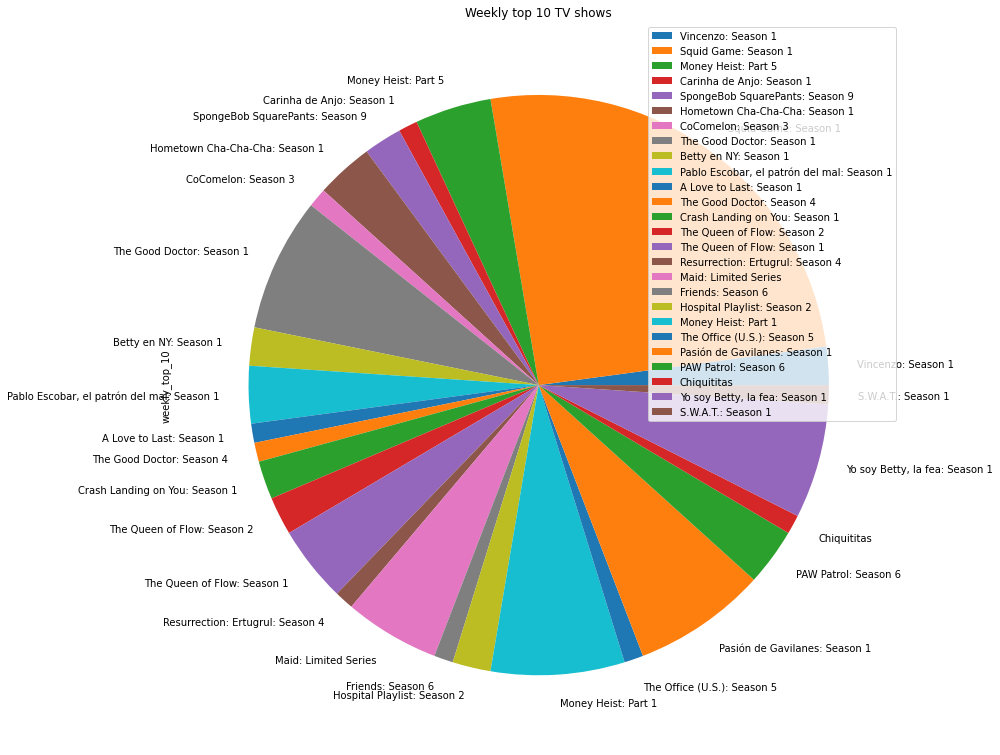

In [ ]:
### Convert the DataFrame to a Pandas DataFrame, and display it as a pie chart
# .toPandas, .plot.pie

graphing = tv_count_df.toPandas()
graphing = graphing.set_index('season_title') # set index to get the titles

graphing.plot.pie(y='weekly_top_10',   # set y as my weekly top 10 from previous cell
                  figsize=(13,20),
                  title='Weekly top 10 TV shows'
                  )


# Exercise 3 - Most popular shows by country (10 Marks)


1.   Calculate the number of weeks each TV show spent in each country's top 10, across all seasons, such that you don't double count a show when two or more seasons appear in one week.
2.   Produce a DataFrame that contains the show which spent the most time in each country's top 10.

In [ ]:
### Group the data by 'country_name' and 'show_title' and count the number of
### weeks each show appears in each country's top 10 lists, as well as the
### highest weekly ranking. Display the data.
# .groupBy, .agg, F.count_distinct, F.min, .sort, .show

popular_shows_df = tv_df.groupby('country_name','show_title')\
                         .agg(F.count_distinct('cumulative_weeks_in_top_10') #once grouped, count_distinct for each shows at top 10
                         .alias('top_10_weekly_shows'),
                         F.min('weekly_rank').alias('weekly_rank'))\
                         .sort(F.col('country_name')) # find highest weekly rank with F.min then sort the country_name column

popular_shows_df.show()

+------------+--------------------+-------------------+-----------+
|country_name|          show_title|top_10_weekly_shows|weekly_rank|
+------------+--------------------+-------------------+-----------+
|   Argentina|           Blindspot|                  1|         10|
|   Argentina|Pablo Escobar, el...|                  5|          8|
|   Argentina|          Archive 81|                  1|          4|
|   Argentina|           Ganglands|                  1|          7|
|   Argentina|             Lucifer|                  3|          2|
|   Argentina|  The Girl from Oslo|                  2|          5|
|   Argentina|Daughter From Ano...|                  1|          7|
|   Argentina|              Arcane|                  3|          3|
|   Argentina|Yo soy Betty, la fea|                 21|          6|
|   Argentina|             The 100|                  2|          5|
|   Argentina|            Sky Rojo|                  3|          2|
|   Argentina|           Cobra Kai|             

In [ ]:
### Find the show that spent the most time in each country's top 10 list.
### Produce and display a table showing that information, along with the number
### of weeks spent in the top 10, and the highest weekly ranking
# .groupBy, .sort, .desc, .agg, F.first, .show

tv_most_df = popular_shows_df.sort(F.col('top_10_weekly_shows').desc())\
                       .groupBy('country_name')\
                       .agg(F.first('show_title').alias('show_title'), #show first for show_title,weekly rank and top 10 weekly 
                        F.first('weekly_rank').alias('weekly_rank'),
                        F.first('top_10_weekly_shows').alias('weeks_top_10'))
                     
                     

tv_most_df.show()

+------------------+--------------------+-----------+------------+
|      country_name|          show_title|weekly_rank|weeks_top_10|
+------------------+--------------------+-----------+------------+
|         Argentina| Pasión de Gavilanes|          4|          36|
|         Australia|      Animal Kingdom|          2|          12|
|           Austria|          Squid Game|          1|          12|
|           Bahamas|SpongeBob SquareP...|          3|          18|
|           Bahrain|          Squid Game|          1|          16|
|        Bangladesh|          Squid Game|          1|          22|
|           Belgium|         Money Heist|          1|          12|
|           Bolivia| Pasión de Gavilanes|          3|          36|
|            Brazil|         Chiquititas|          2|          29|
|          Bulgaria|          Squid Game|          1|          16|
|            Canada|                Maid|          2|          12|
|             Chile|Yo soy Betty, la fea|          1|         

# Exercise 4 - Movie popularity on Netflix (15 Marks)

1.   Calculate, for each Film, the number of weeks it spent in each country's number 1 spot, top 10 lists, and the highest weekly rank.
2.   Produce a Dataframe that, for each Film, contains:
    * the highest rank reached worldwide
    * the highest number of weeks it spent in a single country's top 10
    * the highest number of weeks it spent in a single country's number 1 spot
    * the mean number of weeks it spent in the top 10 lists worldwide
    * the mean number of weeks it spent in the number 1 spot worldwide
    * the number of countries where it reached the top 10
    * the number of countries where it reached the number 1 spot

In [ ]:
### Find the highest weekly rank for each film in each country
### Calculate the number of weeks each film spent in each country's top 10
### Calculate the number of weeks each film spent at number 1 in each country
### Produce a DataFrame grouped by 'country_name' and 'show_title' and display
# F.min, F.count_distinct, F.when, .otherwise, .groupBy, .agg, .sort, .show
#cnt_cond = lambda cond: F.count_distinct(F.when(cond, 1).otherwise(0))



films_df_1 = films_df.groupby('country_name','show_title')\
                     .agg(F.min('weekly_rank').alias('weekly_rank'),
                          F.count_distinct('cumulative_weeks_in_top_10').alias('weekly_top_10'),
                         F.when(F.min('weekly_rank') == 1, F.count_distinct('cumulative_weeks_in_top_10')).otherwise(0).alias('number 1 weekly'))\
                     .sort(F.col('country_name')) # when min weekly rank is 1, count distinct for cumulative weekly 1


films_df_1.show()

+------------+--------------------+-----------+-------------+---------------+
|country_name|          show_title|weekly_rank|weekly_top_10|number 1 weekly|
+------------+--------------------+-----------+-------------+---------------+
|   Argentina|            Hypnotic|          3|            2|              0|
|   Argentina|     The Hand of God|          7|            1|              0|
|   Argentina|The Father Who Mo...|          3|            2|              0|
|   Argentina|       He's All That|          2|            3|              0|
|   Argentina|  My Father's Violin|          4|            1|              0|
|   Argentina|       Silver Skates|          7|            1|              0|
|   Argentina|The Forgotten Battle|          1|            3|              3|
|   Argentina|    Der Fall Collini|          6|            1|              0|
|   Argentina|Trollhunters: Ris...|          3|            1|              0|
|   Argentina|              Faster|         10|            1|   

In [ ]:
### Find the highest weekly rank reached worldwide for each film
### Calculate the maximum and mean weeks each film was at number 1
### Calculate the maximum and mean weeks each film was in the top 10
### Count the countries where each film reached the top 10 and number 1
### Produce a DataFrame grouped by 'show_title' and display
# F.min, F.max, F.mean, F.count_distinct, F.when, .otherwise, .groupBy, .agg,
# .sort, .show

""" when weekly rank at 1 count the distinct weeks , mean and country name and sort by show title  """


films_world_df = films_df.groupBy('show_title')\
                          .agg(F.min('weekly_rank').alias('top_rank'), 
                               F.max('cumulative_weeks_in_top_10').alias('number of times at top 10'), 
                               F.mean('cumulative_weeks_in_top_10').alias('mean of weeks at top 10'),
                               F.when(F.min('weekly_rank').alias('top_rank') == 1, F.count_distinct('cumulative_weeks_in_top_10')).otherwise(0).alias('weeks at 1st'), 
                               F.when(F.min('weekly_rank').alias('top_rank') == 1, F.mean('cumulative_weeks_in_top_10')).otherwise(0).alias('mean of weeks at 1st'),
                               F.when(F.min('weekly_rank').alias('top_rank') == 1, F.count_distinct('country_name')).otherwise(0).alias('countries')) \
                               .sort(F.col('show_title'))


films_world_df.show()
